# API Design for sklearn rewrite of maxentropy

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()

iris.keys()

X = iris.data
y = iris.target

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
model_lr = LogisticRegression(max_iter=10_000)

In [6]:
model_lr.fit(X, y)

LogisticRegression(max_iter=10000)

In [7]:
model_lr.coef_

array([[-0.42297784,  0.96737285, -2.51559259, -1.08055747],
       [ 0.53460191, -0.32246744, -0.20680669, -0.94445271],
       [-0.11162407, -0.64490541,  2.72239928,  2.02501018]])

In [8]:
model_lr.score(X, y)

0.9733333333333334

## Idea: fit a maxentropy model for each of the subsets of data given by the discrete training labels.

In [9]:

import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import maxentropy
import maxentropy.utils as utils

### Feature functions

In [10]:
def f0(X):
    return X[:, 0]**2

def f1(X):
    return X[:, 1]**2

def f2(X):
    return X[:, 2]**2

def f3(X):
    return X[:, 3]**2

def f4(X):
    """
    Petal length * petal width
    """
    return X[:, 1] * X[:, 2]

def f5(X):
    return X[:, 0]
    
def f6(X):
    return X[:, 1]

def f7(X):
    return X[:, 2]
    
def f8(X):
    return X[:, 3]
    

features = [f0, f1, f2, f3, f4, f5, f6, f7, f8]

### Define a sampler

In [11]:
stretched_minima, stretched_maxima = utils.bounds_stretched(X)

In [12]:
import scipy.stats

uniform_dist = scipy.stats.uniform(stretched_minima, stretched_maxima - stretched_minima)

In [13]:
sampler = utils.auxiliary_sampler_scipy(uniform_dist, n_dims=len(iris['feature_names']), n_samples=10_000)

In [14]:
clf = maxentropy.MinKLClassifier(feature_functions=features, auxiliary_sampler=sampler, verbose=True)

In [15]:
clf.fit(X, y)

Fitting model for target 0


/Users/schofield/anaconda/envs/maxentropy/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: -0.433152
         Iterations: 1000
         Function evaluations: 1908
         Gradient evaluations: 1908
Fitting model for target 1


/Users/schofield/anaconda/envs/maxentropy/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 1.333642
         Iterations: 679
         Function evaluations: 1290
         Gradient evaluations: 1290
Fitting model for target 2
         Current function value: 2.003230
         Iterations: 978
         Function evaluations: 1873
         Gradient evaluations: 1873


/Users/schofield/anaconda/envs/maxentropy/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


MinKLClassifier(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x16c8c0640>,
                feature_functions=[<function f0 at 0x16c8e8fe0>,
                                   <function f1 at 0x16c8e9080>,
                                   <function f2 at 0x16c8e9120>,
                                   <function f3 at 0x16c8e91c0>,
                                   <function f4 at 0x16c8e9260>,
                                   <function f5 at 0x16c8e9300>,
                                   <function f6 at 0x16c8e93a0>,
                                   <function f7 at 0x16c8e9440>,
                                   <function f8 at 0x16c8e94e0>],
                verbose=True)

In [16]:
clf.models[0].params

array([ -5.07162699,  -2.98969621, -19.63699219, -60.73615925,
         5.39190638,  50.25873186,  12.69234977,  38.93663678,
        29.43039084])

In [17]:
clf.models[0].feature_expectations()

array([25.1817998 , 11.89200205,  2.16700038,  0.07140088,  5.02320173,
        5.00599961,  3.42800063,  1.46200024,  0.2460008 ])

In [18]:
clf.models[0].K

array([25.1818, 11.892 ,  2.167 ,  0.0714,  5.0232,  5.006 ,  3.428 ,
        1.462 ,  0.246 ])

In [19]:
clf.predict_log_proba(X[0:2])

array([[  0.        , -55.47221001, -64.1483727 ],
       [  0.        , -45.59181093, -57.64620898]])

In [20]:
clf.predict_proba(X[0:1])

array([[1.00000000e+00, 8.10448259e-25, 1.38266100e-28]])

In [21]:
clf.predict(X[0:1])

array([0])

In [22]:
y[0]

0

In [23]:
clf.predict_proba(X[50:52])

array([[2.44434563e-134, 9.11483616e-001, 8.85163837e-002],
       [7.79076746e-126, 9.73899728e-001, 2.61002720e-002]])

In [24]:
clf.predict(X[50:52])

array([1, 1])

In [25]:
y[50:52]

array([1, 1])

In [26]:
clf.score(X, y)

0.9666666666666667

In [27]:
# !pip install yellowbrick

In [28]:
from yellowbrick.classifier import confusion_matrix

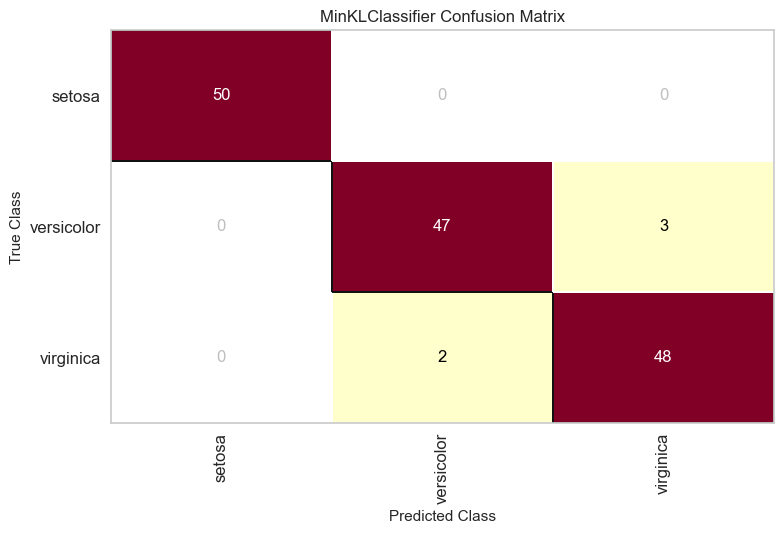

ConfusionMatrix(ax=<Axes: title={'center': 'MinKLClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
                cmap=<matplotlib.colors.ListedColormap object at 0x175584cd0>,
                estimator=MinKLClassifier(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x16c8c0640>,
                                          feature_functions=[<function f0 at 0x16c8e8fe0>,
                                                             <function f1 at 0x16c8e9080>,
                                                             <function f2 at 0x16c8e9120>,
                                                             <function f3 at 0x16c8e91c0>,
                                                             <function f4 at 0x16c8e9260>,
                                                             <function f5 at 0x16c8e9300>,
                                                             <function f6 at 0x16c8e93a0>,
                                                             <function f7 at 0x16c8e9440>,
                                                             <function f8 at 0x16c8e94e0>],
                                          verbose=True))

In [29]:
confusion_matrix(clf, X, y, classes=iris['target_names'])

#### Versus this for logistic regression above:

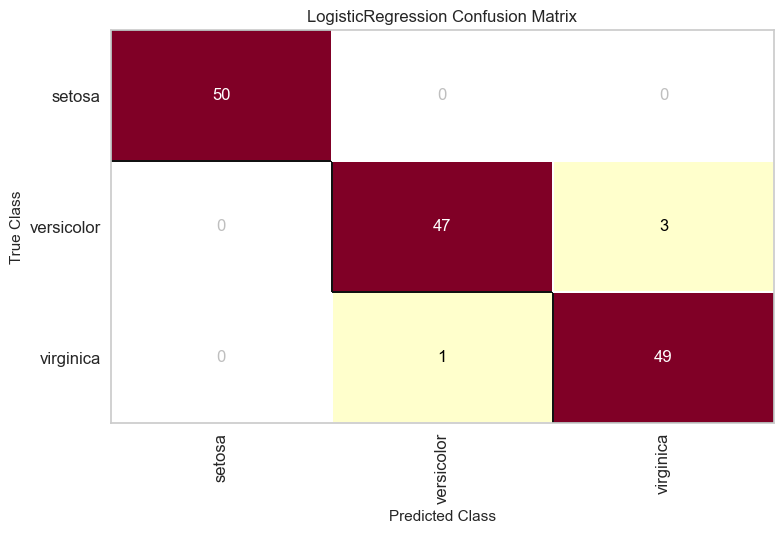

ConfusionMatrix(ax=<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
                cmap=<matplotlib.colors.ListedColormap object at 0x175665c90>,
                estimator=LogisticRegression(max_iter=10000))

In [30]:
confusion_matrix(model_lr, X, y, classes=iris['target_names'])

In [31]:
clf.models[0].params

array([ -5.07162699,  -2.98969621, -19.63699219, -60.73615925,
         5.39190638,  50.25873186,  12.69234977,  38.93663678,
        29.43039084])

### Now try with the cancer dataset

In [32]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer(as_frame=True)

In [33]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [34]:
X = cancer['data']
y = cancer['target']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [36]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [37]:
model2_lr = LogisticRegression(max_iter=10000)
model2_lr.fit(X_train, y_train)
model2_lr.score(X_test, y_test)

0.965034965034965

#### Now try with maxentropy for comparison

We define the same feature functions as before:

In [38]:
X.shape

(569, 30)

Constrain each column's mean and variance:

In [39]:
features = []
for col_num in range(X.shape[1]):
    def generate_feature(col_num):
        def f_col(X):
            return X[:, col_num]
        def f_col_square(X):
            return X[:, col_num]**2
        return f_col, f_col_square
    features += generate_feature(col_num)

In [40]:
# Override: just add two constraints, for debugging:
features = []
for col_num in range(1):
    def generate_feature(col_num):
        def f_col(X):
            return X[:, col_num]
        def f_col_square(X):
            return X[:, col_num]**2
        return f_col, f_col_square
    features += generate_feature(col_num)

In [41]:
len(features)

2

In [42]:
stretched_minima, stretched_maxima = utils.bounds_stretched(X_train)
uniform_dist = scipy.stats.uniform(
    stretched_minima, stretched_maxima - stretched_minima
)
sampler = utils.auxiliary_sampler_scipy(
    uniform_dist, n_dims=len(cancer["feature_names"]), n_samples=64  # _000
)

In [43]:
next(sampler)[0].shape

(64, 30)

In [48]:
model2_maxentropy = maxentropy.MinKLClassifier(features, sampler, verbose=1, max_iter=5_000, warm_start=True)

In [49]:
# model2_maxentropy.algorithm = 'SGD'

In [50]:
# model2_maxentropy.step_size_sgd = 0.01
# model2_maxentropy.models[0].staticsample = False
# model2_maxentropy.models[1].staticsample = False
# model2_maxentropy.matrixtrials

In [51]:
model2_maxentropy.fit(X_train, y_train)

Fitting model for target 0
         Current function value: 20.128790
         Iterations: 16
         Function evaluations: 83
         Gradient evaluations: 63
Fitting model for target 1
Optimization terminated successfully.
         Current function value: 19.531785
         Iterations: 12
         Function evaluations: 41
         Gradient evaluations: 37


/Users/schofield/anaconda/envs/maxentropy/lib/python3.11/site-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


MinKLClassifier(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x16c8c1940>,
                feature_functions=[<function generate_feature.<locals>.f_col at 0x16c8e96c0>,
                                   <function generate_feature.<locals>.f_col_square at 0x16c8e8ea0>],
                max_iter=5000, verbose=1, warm_start=True)

In [52]:
model2_maxentropy.score(X_test, y_test)

0.9020979020979021

In [54]:
model2_lr.score(X_test, y_test)

0.965034965034965

In [ ]:
model2_maxentropy.models[0].warm_start, model2_maxentropy.models[0].params

In [ ]:
model2_maxentropy.algorithm = 'CG'
model2_maxentropy.models[0].algorithm = 'CG'
model2_maxentropy.models[1].algorithm = 'CG'

In [ ]:
model2_maxentropy.fit(X_train, y_train)

In [ ]:
model2_maxentropy.models[0].warm_start, model2_maxentropy.models[0].params

In [ ]:
model2_maxentropy.score(X_test, y_test)

In [ ]:
BREAK

Not bad versus logistic regression, considering we are just doing the braindead thing still, and we have so few parameters (here 60 x 3 = 180).

In [ ]:
model2_lr.score(X_test, y_test)

(But logistic regression has even fewer:)

## Reranking an existing model

Can we improve on the existing LR model?

Ideally we'd first now how it's poor, then impose constraints to correct for that.

But here we'll just try imposing the same constraints on mean and variance of every individual column to be equal to those in the data for that class.

In [ ]:
# def mean_radius(X):
#     return np.array(X)[:, 0]

# def mean_texture(X):
#     return np.array(X)[:, 1]

In [ ]:
# features = [mean_radius, mean_texture]

In [ ]:
# sampler = utils.auxiliary_sampler_scipy(uniform_dist, n_dims=len(iris['feature_names']), n_samples=10_000)

In [ ]:
model_rerank = maxentropy.MinKLClassifier(
    feature_functions=features, auxiliary_sampler=sampler,
    prior_log_proba_fn=model2_lr.predict_log_proba, verbose=1, max_iter=10_000
)
model_rerank.fit(X_train, y_train)

In [ ]:
model_rerank.score(X_test, y_test)

In [ ]:
model2_lr.score(X_test, y_test)

### Try rereanking a dummy classifier. Does it improve?

In [ ]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

In [ ]:
model_rerank = maxentropy.MinKLClassifier(
    feature_functions=features, auxiliary_sampler=sampler,
    prior_log_proba_fn=dummy.predict_log_proba, verbose=1, max_iter=10_000
)
model_rerank.fit(X_train, y_train)

In [ ]:
model_rerank.score(X_test, y_test)

In [ ]:
BREAK

### Older notes / API ideas

In [ ]:
import numpy as np

np.mean(petal_length(setosa))

In [ ]:
import numpy as np

np.mean(petal_length(versicolor))

In [ ]:
import numpy as np

np.mean(petal_length(virginica))

In [ ]:
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype'

In [ ]:
import plotly.express as px
import pandas as pd

In [ ]:
# df = iris.frame

In [ ]:
df = pd.DataFrame(X, columns=iris.feature_names)
df['target_class'] = y

In [ ]:
df['target_name'] = iris.target_names[y]

In [ ]:
df[:3]

In [ ]:
px.histogram(df, x='petal length (cm)', color='target_name')

In [ ]:
px.scatter(df, x='petal length (cm)', y='sepal length (cm)', color='target_name')

### API ideas

In [ ]:
features = [petal_length, sepal_length]
means = [np.mean(petal_length(X)), np.mean(sepal_length(X))]
means

This design is flexible, allowing us to pass in some feature expectations based on prior knowledge.

In [ ]:
new_model = ConditionalReRanker(model)
new_model.fit(features, means)

Note that we also need to get the log probabilities somehow of the original model on the entire sample space. Is this possible?

In [ ]:
# The following API would be more consistent with sklearn but
# less flexible (requireing that we always compute the feature expectations on a dataset):
# new_model = ConditionalReRanker(model, features)
# new_model.fit(X, y)

So let's go with the first one. First, an unconditional model:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, DensityMixin

In [ ]:
from maxentropy.skmaxent import MinDivergenceModel

In [ ]:
class MinDivergenceReRanker(BaseEstimator, DensityMixin, BaseModel):
    def __init__(self, original_estimator: BaseEstimator, samplespace):
        super().__init__()
        self.original_estimator = original_estimator
        self.samplespace = samplespace
    def fit(self, features, means):
        prior_log_prob = self.original_estimator.predict_log_proba(X)
        self.min_div_model = MinDivergenceModel(features, self.samplespace, prior_log_prob=prior_log_prob)
        means = 
        self.min_div_model.fit(means)

In [ ]:
from scipy.stats import uniform

In [ ]:
min_petal_length = 0.0
min_petal_length

In [ ]:
max_petal_length = np.max(petal_length(X)) * 1.5
max_petal_length

In [ ]:
petal_length_gen = uniform(min_petal_length, max_petal_length)